# Weather Forecasting with XGBOOST and Prophet

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import xgboost as xgb
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from prophet import Prophet 

## Load Data

In [2]:
# Note test data date begins where train data ends
climate_train = pd.read_csv("./data/DailyDelhiClimateTrain.csv")
climate_test = pd.read_csv("./data/DailyDelhiClimateTest.csv")

climate_train = climate_train.dropna()
climate_test = climate_test.dropna()

In [3]:
climate_test.tail()

,date,meantemp,humidity,wind_speed,meanpressure
109,2017-04-20,34.500,27.500000,5.562500,998.625000
110,2017-04-21,34.250,39.375000,6.962500,999.875000
111,2017-04-22,32.900,40.900000,8.890000,1001.600000
112,2017-04-23,32.875,27.500000,9.962500,1002.125000
113,2017-04-24,32.000,27.142857,12.157143,1004.142857


In [4]:
climate_train = climate_train.set_index("date")
climate_test = climate_test.set_index("date")

climate_train.index = pd.to_datetime(climate_train.index)
climate_test.index = pd.to_datetime(climate_test.index)

Text(0.5, 0, 'Date')

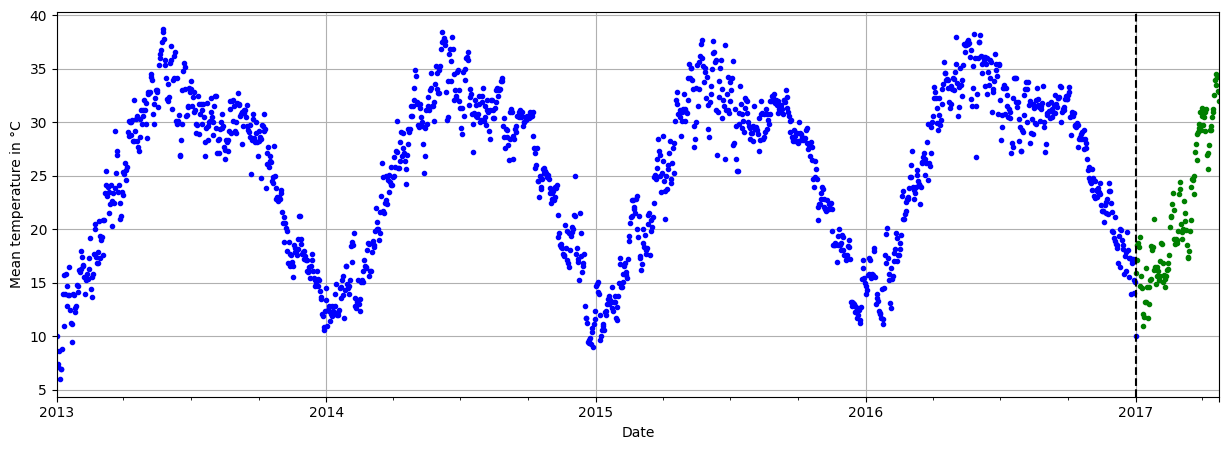

In [5]:
fig, ax = plt.subplots(figsize = (15,5))
climate_train['meantemp'].plot(style = '.',  
                               label = 'Train data',
                               color = 'blue'
                               )
climate_test['meantemp'].plot(style = '.', 
                               label = 'Test data',
                               color = 'green'
                               )


ax.axvline(climate_test.index.min(), color = 'black', ls = '--')
plt.grid()
plt.ylabel("Mean temperature in °C")
plt.xlabel("Date")
# We can detect a seasonal pattern 

In [6]:
climate_train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [7]:
def create_features(climate: pd.DataFrame):
    """
    Create time series features based on time series index 
    """
    climate = climate.copy()
    #climate['hour'] = climate.index.hour
    climate['dayofweek'] = climate.index.dayofweek
    climate['quarter'] = climate.index.quarter
    climate['month'] = climate.index.month
    climate['year'] = climate.index.year
    climate['dayofyear'] = climate.index.dayofyear
    return climate

In [8]:
climate_train = create_features(climate_train)
climate_test = create_features(climate_test)

In [9]:
# Set Font Sizes
LBF = 14 # Label font size 
LGF = 14 # Legend font size 
TLS = 16 # Title size 
TS = 12 # Tick size 

Text(0.5, 1.0, 'Yearly trend')

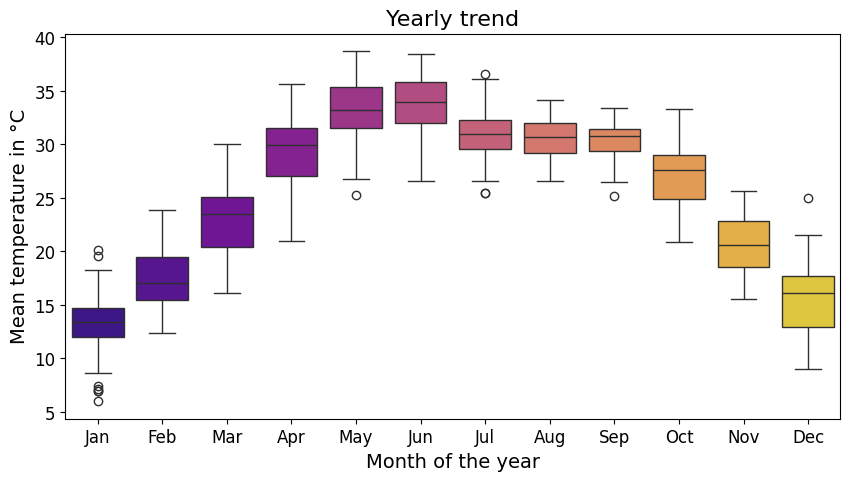

In [10]:
# Monthly trend 
fig, ax = plt.subplots(figsize = (10,5))
palette1 = sns.color_palette(palette='plasma', n_colors = 12)
sns.boxplot(data=climate_train, x ='month', y = "meantemp", palette=palette1)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(ax.get_xticks(), months)

plt.xlabel('Month of the year', fontsize = LBF)
plt.ylabel('Mean temperature in °C', fontsize = LBF)

ax.tick_params(axis='both', which='major', labelsize=TS)
plt.title("Yearly trend", fontsize = TLS)


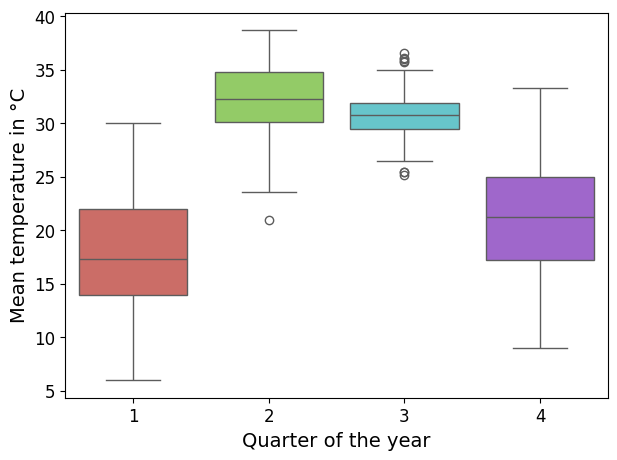

In [11]:
# Quaterly trend 
fig, ax = plt.subplots(figsize = (7,5))
palette1 = sns.color_palette(palette="hls", n_colors = 4)
sns.boxplot(data=climate_train, x ='quarter', y = "meantemp", palette=palette1)

plt.xlabel('Quarter of the year', fontsize = LBF)
plt.ylabel('Mean temperature in °C', fontsize = LBF)

ax.tick_params(axis='both', which='major', labelsize=TS)

# Create Model using XGBoost 

In [12]:
FEATURES = ['dayofweek','quarter','month','year','dayofyear','humidity','wind_speed', 'meanpressure']
TARGET = ['meantemp']

In [13]:
X_train = climate_train[FEATURES]
y_train = climate_train[TARGET]

X_test = climate_test[FEATURES]
y_test= climate_test[TARGET]

In [14]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=50, learning_rate = 0.01) # learing_rate so it does not overfit too quickly 

reg.fit(X_train, y_train, 
        eval_set = [(X_train,y_train),(X_test, y_test)],
        verbose=True)

[0]	validation_0-rmse:7.27747	validation_1-rmse:7.30198
[1]	validation_0-rmse:7.21008	validation_1-rmse:7.22864
[2]	validation_0-rmse:7.14339	validation_1-rmse:7.15603
[3]	validation_0-rmse:7.07738	validation_1-rmse:7.08486
[4]	validation_0-rmse:7.01207	validation_1-rmse:7.01399
[5]	validation_0-rmse:6.94745	validation_1-rmse:6.94399
[6]	validation_0-rmse:6.88349	validation_1-rmse:6.87495
[7]	validation_0-rmse:6.82021	validation_1-rmse:6.80665
[8]	validation_0-rmse:6.75753	validation_1-rmse:6.74014
[9]	validation_0-rmse:6.69555	validation_1-rmse:6.67384
[10]	validation_0-rmse:6.63416	validation_1-rmse:6.60826
[11]	validation_0-rmse:6.57342	validation_1-rmse:6.54422
[12]	validation_0-rmse:6.51336	validation_1-rmse:6.48067
[13]	validation_0-rmse:6.45388	validation_1-rmse:6.41760
[14]	validation_0-rmse:6.39502	validation_1-rmse:6.35488
[15]	validation_0-rmse:6.33682	validation_1-rmse:6.29425
[16]	validation_0-rmse:6.27917	validation_1-rmse:6.23394
[17]	validation_0-rmse:6.22214	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
fi = pd.DataFrame(data=reg.feature_importances_, 
                  index = reg.feature_names_in_, 
                  columns = ['importance'])
fi

,importance
dayofweek,0.001823
quarter,0.018598
month,0.014034
year,0.015662
dayofyear,0.055156
humidity,0.041816
wind_speed,0.003157
meanpressure,0.849753


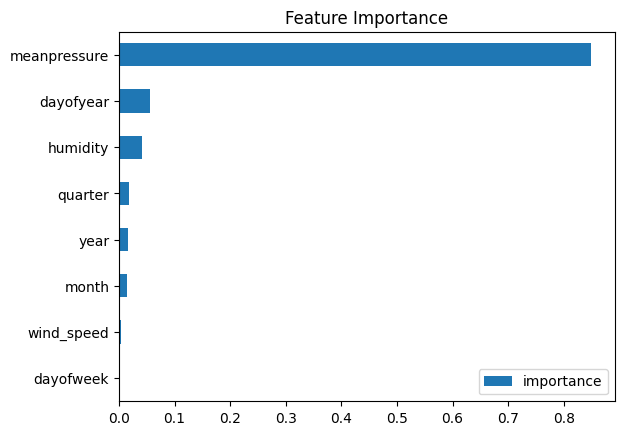

In [16]:
fi.sort_values('importance').plot(kind='barh', title = 'Feature Importance')
plt.legend(loc = 'lower right')
ax.tick_params(axis='both', which='major', labelsize=TS)

In [17]:
climate_test['meantemp prediction'] = reg.predict(X_test)

Text(0.5, 1.0, 'Temperature Forecast with XGBoost')

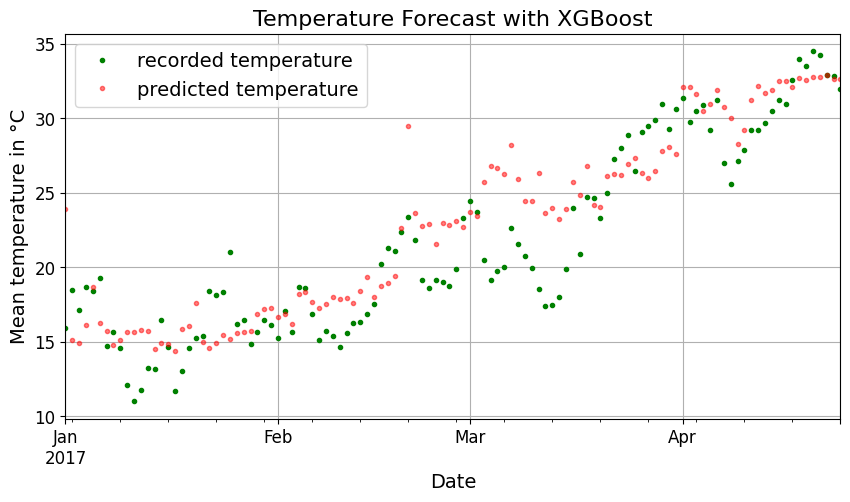

In [18]:
fig, ax = plt.subplots(figsize = (10,5))

climate_test['meantemp'].plot(style = '.', 
                               label = 'recorded temperature',
                               color = 'green'
                               )
climate_test['meantemp prediction'].plot(style = '.', 
                               label = 'predicted temperature',
                               color = 'red',
                               alpha = 0.5
                               )


plt.grid()
plt.ylabel("Mean temperature in °C", fontsize = LBF)
plt.xlabel("Date", fontsize = LBF)

plt.legend(loc='upper left', fontsize = LGF)
ax.tick_params(axis='both', which='major', labelsize=TS)

plt.title('Temperature Forecast with XGBoost', fontsize = TLS)

In [19]:
# For regression tasks
mae = mean_absolute_error(climate_test['meantemp'], climate_test['meantemp prediction'])
mse = mean_squared_error(climate_test['meantemp'], climate_test['meantemp prediction'])
r2 = r2_score(climate_test['meantemp'], climate_test['meantemp prediction'])

# Print or use the metrics as needed
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 2.3893044954505402
Mean Squared Error: 9.14646672253364
R-squared: 0.7718840130478737


## Extended dataset
Since the first dataset does not provide testing data for a very long period a new dataset was found on https://www.kaggle.com/datasets/vanvalkenberg/historicalweatherdataforindiancities/data.
</br> However, this dataset only incudes tavg, tmin, tmax and prep. Additonally, a lot of entries are missing from prcp. </br> Empty cells in prcp are not dropped since it would reduce the dataset significantly.


In [20]:
Delhi_NCR = pd.read_csv("./data/Delhi_NCR_1990_2022_Safdarjung.csv")
#Delhi_NCR = Delhi_NCR.dropna()
Delhi_NCR = Delhi_NCR.rename(columns={"time": "date", "tavg": "meantemp"})
Delhi_NCR = Delhi_NCR.set_index("date")
Delhi_NCR.index = pd.to_datetime(Delhi_NCR.index, format='%d-%m-%Y')


In [21]:
Delhi_NCR

,meantemp,tmin,tmax,prcp
date,,,,
1990-01-01,9.4,6.0,15.1,0.0
1990-01-02,9.3,5.2,14.2,0.0
1990-01-03,9.0,6.5,13.6,0.0
1990-01-04,10.7,6.0,17.5,0.0
1990-01-05,12.6,7.3,20.8,0.0
...,...,...,...,...
2022-07-21,28.6,26.8,30.6,21.2
2022-07-22,29.3,27.0,32.9,0.3
2022-07-23,30.1,25.5,34.9,8.9


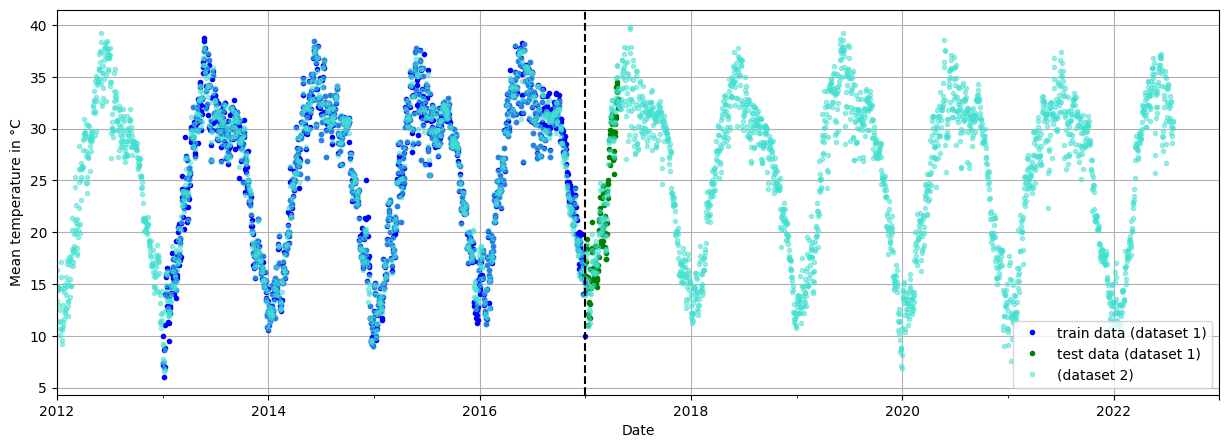

In [22]:
fig, ax = plt.subplots(figsize = (15,5))
climate_train['meantemp'].plot(style = '.',  
                               color = 'blue',
                               label = 'train data (dataset 1)'
                               )
climate_test['meantemp'].plot(style = '.', 
                               color = 'green',
                               label = 'test data (dataset 1)'
                               )
Delhi_NCR['meantemp'].plot(style = '.',
                               color = 'turquoise',
                               alpha = 0.5,
                               label= '(dataset 2)'
                               )

ax.axvline(climate_test.index.min(), color = 'black', ls = '--')
plt.xlim(pd.to_datetime('2012-01-01'), pd.to_datetime('2023-01-01'))
plt.legend(loc = 'lower right')
plt.ylabel("Mean temperature in °C")
plt.xlabel("Date")

plt.grid()
# We can detect a seasonal pattern 

In [23]:
n_years = 6
period = int(n_years*365)

df_train = Delhi_NCR[Delhi_NCR.index < climate_train.index.max()].reset_index()

#Forecasting 
df_train = df_train[['date','meantemp']]
df_train = df_train.rename(columns={"date":"ds", "meantemp":"y"})

df_train.head()
m = Prophet()
m.fit(df_train)
future = m.make_future_dataframe(periods=period)
forecast = m.predict(future)

21:57:05 - cmdstanpy - INFO - Chain [1] start processing
21:57:07 - cmdstanpy - INFO - Chain [1] done processing


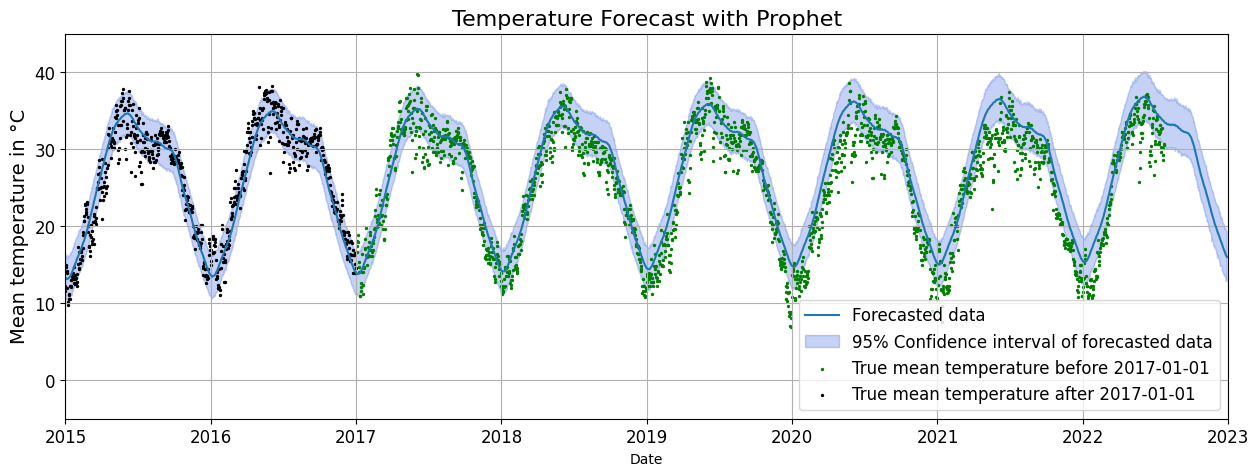

In [27]:
fig, ax = plt.subplots(figsize = (15,5))

df_test = Delhi_NCR[Delhi_NCR.index > climate_train.index.max()].reset_index()

ax.plot(forecast['ds'], forecast['yhat'], label = 'Forecasted data')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='royalblue', alpha=0.3, label='95% Confidence interval of forecasted data')
plt.scatter(df_test['date'], df_test['meantemp'], s = 2, color = 'green', label =rf'True mean temperature before {climate_train.index.max().strftime('%Y-%m-%d')}')
plt.scatter(df_train['ds'], df_train['y'], s = 2, color = 'black', label =rf'True mean temperature after {climate_train.index.max().strftime('%Y-%m-%d')}')

plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2023-01-01'))
plt.ylim(-5,45)

plt.xlabel('Date')
plt.ylabel('Mean temperature in °C', fontsize = LBF)
plt.legend(loc='lower right', fontsize = LGF-2)
ax.tick_params(axis='both', which='major', labelsize=TS)

plt.title('Temperature Forecast with Prophet', fontsize = TLS)
plt.grid()




In [25]:
from prophet.plot import plot_plotly
from plotly import graph_objs as go  

df_test = Delhi_NCR[Delhi_NCR.index > climate_train.index.max()].reset_index()

fig1 = plot_plotly(m, forecast)

# Add a scatter plot
fig1.add_trace(go.Scatter(
    x=df_test['date'],
    y=df_test['meantemp'],
    mode='markers',
    marker=dict(color='red', size=2),
    name='true data'
))

fig1.update_xaxes(
    range=['2015-01-01', '2023-01-01']  # Set your desired date range
)

# Add legend
fig1.update_layout(
    title='Forecasted Mean Temperature Plot',
    xaxis_title='Date',
    yaxis_title='Mean temperature in °C',
    legend=dict(
        title='Legend Title',
        orientation='h',  # 'h' for horizontal, 'v' for vertical
        x=0.5,  # Adjust the legend position horizontally
        y=1.1,  # Adjust the legend position vertically
    )
)

fig1.show()

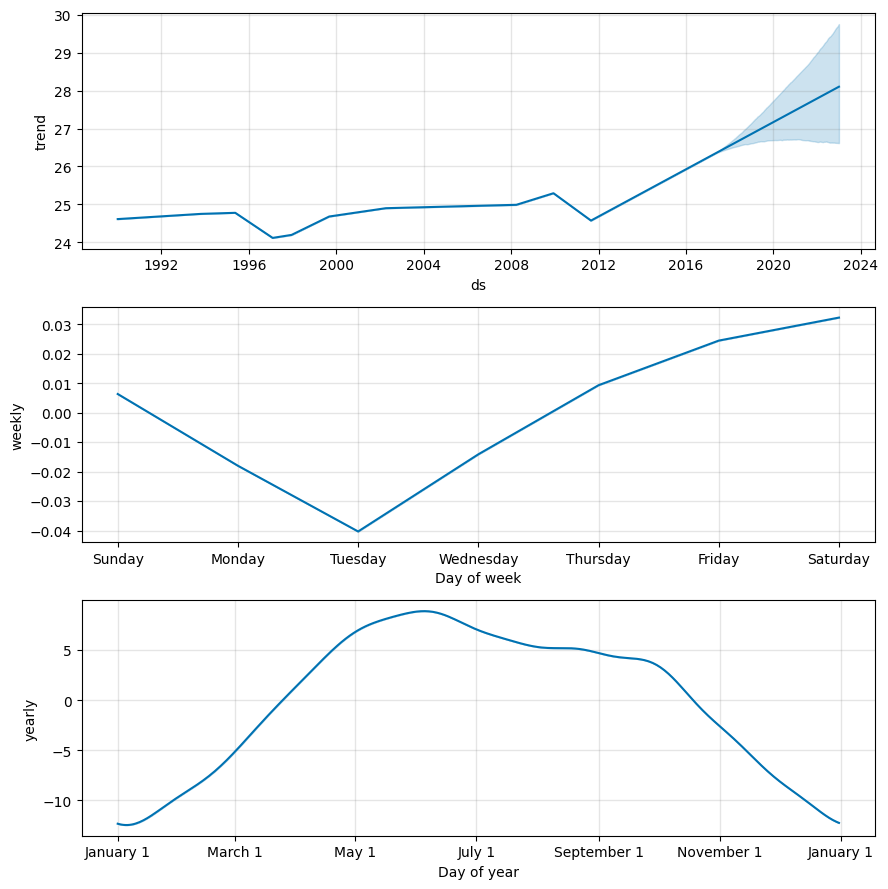

In [26]:
fig2 = m.plot_components(forecast)